Building likelihood maps for a set of representative images.

> TODO: use images from dataset and superimpose the bounding boxes on them


In [1]:
import retinoto_py as fovea
subset_factor = 50
args = fovea.Params(do_fovea=True, batch_size=1, subset_factor=subset_factor)
args

Params(image_size=224, grid_size=224, do_mask=False, do_fovea=True, rs_min=0.0, rs_max=-7.5, angle_start=-0.7853981633974483, angle_margin=0, mode='bilinear', padding_mode='zeros', seed=2025, batch_size=1, num_workers=0, in_memory=False, model_name='convnext_base', num_epochs=41, subset_factor=50, lr=2e-07, delta1=0.2, delta2=0.007, weight_decay=0.003, label_smoothing=0.05, do_full_training=False, shuffle=True, verbose=False)

In [2]:
resolution = (100, 100)
resolution = (30, 30)
resolution = (25, 25)
resolution = (15, 15)
size_ratio = .750
from torchvision.transforms.functional import InterpolationMode, resize
image_size_full = 512


# comparing datasets and models (fovea vs cartesian)

In [5]:

for do_fovea in [True, False]:
    for dataset in fovea.params.all_datasets:
        args = fovea.Params(do_mask=not(do_fovea), do_fovea=do_fovea, 
                            batch_size=1, subset_factor=subset_factor)
        npz_filename = args.data_cache / f'43_likelihood_maps_dataset={dataset}_{do_fovea=}.npz'
        # %rm {npy_filename}  # FORCING RECOMPUTE
        if npz_filename.exists():
            with fovea.np.load(npz_filename) as data:
                likelihood_maps_label = data['likelihood_maps_label']
                likelihood_maps_max = data['likelihood_maps_max']
        else:
            VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
            val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, do_full_preprocess=False)
            val_loader = fovea.get_loader(args, val_dataset)

            if do_fovea:
                model_filename = args.data_cache /  f'32_fovea_model_name={args.model_name}_dataset=bbox.pth'
            else:
                model_filename = args.data_cache /  f'20_model_name={args.model_name}_dataset=bbox.pth'
            model = fovea.load_model(args, model_filename=model_filename)

            n_dataset = len(val_dataset)
            likelihood_maps_label = fovea.np.empty((resolution[0], resolution[1], n_dataset))
            likelihood_maps_max = fovea.np.empty((resolution[0], resolution[1], n_dataset))
            for i_batch, (image, true_idx) in fovea.tqdm(enumerate(val_loader), total=n_dataset):
                image = image.to(args.device)
                image = image.squeeze(0)
                three, H, W = image.shape

                if max((H, W)) > image_size_full:
                    image = resize(image, image_size_full, interpolation=InterpolationMode.BILINEAR, antialias=True)
                # image = fovea.squarify(image.squeeze(0))

                three, H, W = image.shape
                pos_H, pos_W = fovea.get_positions(H, W, resolution=resolution)
                probas = fovea.compute_likelihood_map(args, model, image, pos_H, pos_W, size_ratio=size_ratio)

                likelihood_maps_label[:, :, i_batch] = probas[:, true_idx].cpu().numpy().reshape(resolution)
                proba_max, _ = probas.max(axis=-1)
                likelihood_maps_max[:, :, i_batch] = proba_max.cpu().numpy().reshape(resolution)
            fovea.np.savez(npz_filename, 
                likelihood_maps_max=likelihood_maps_max,
                likelihood_maps_label=likelihood_maps_label,
                )   



  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

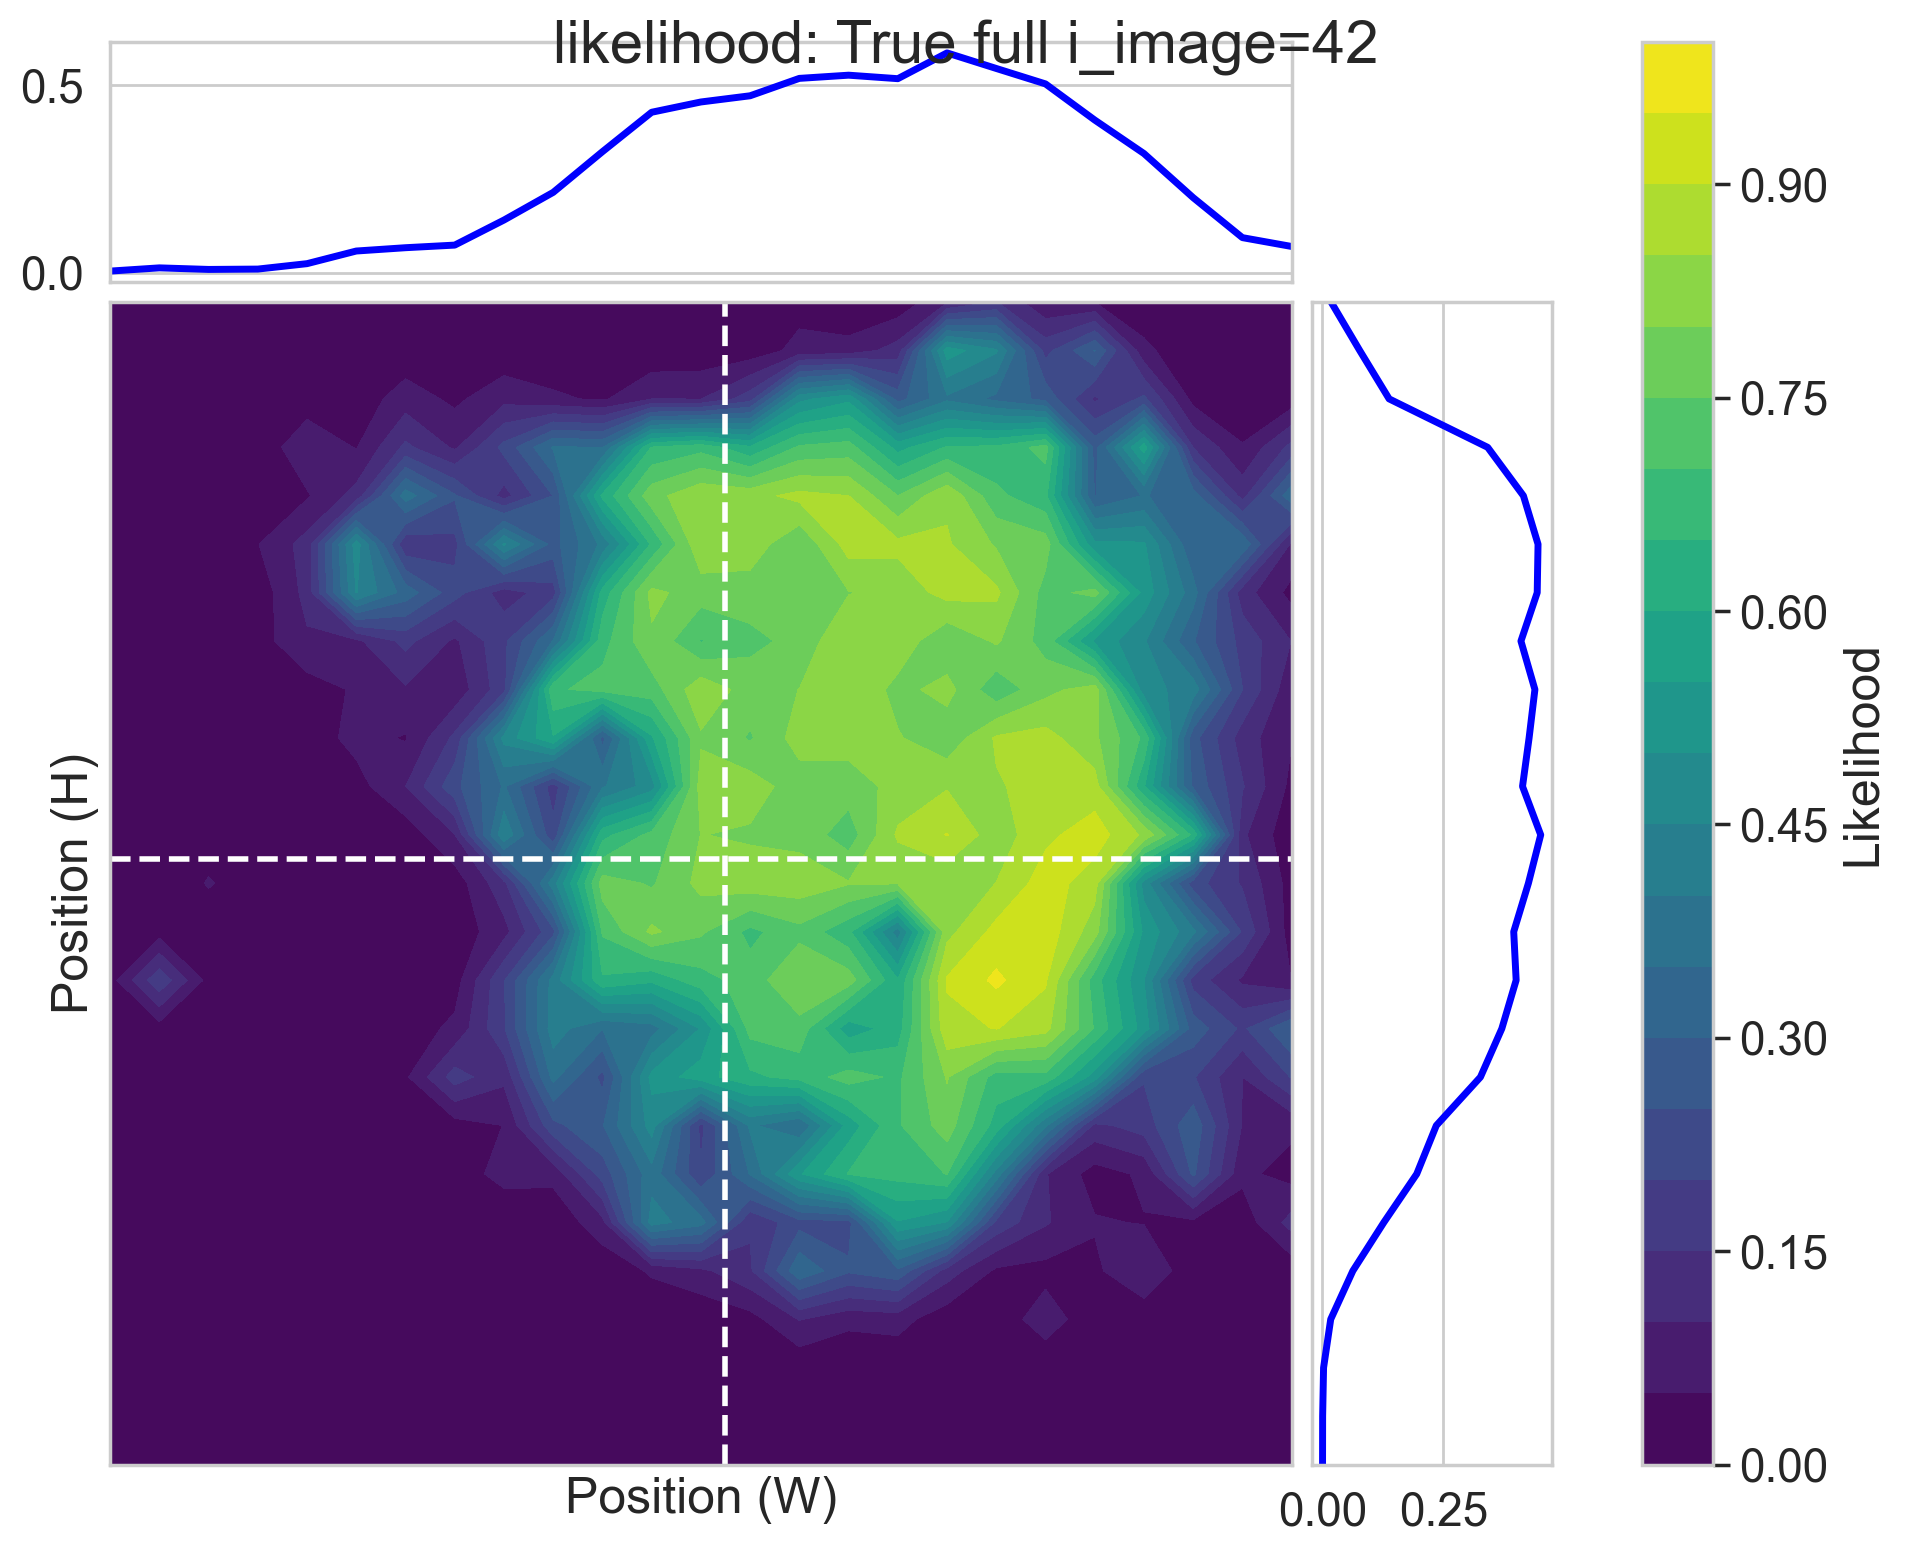

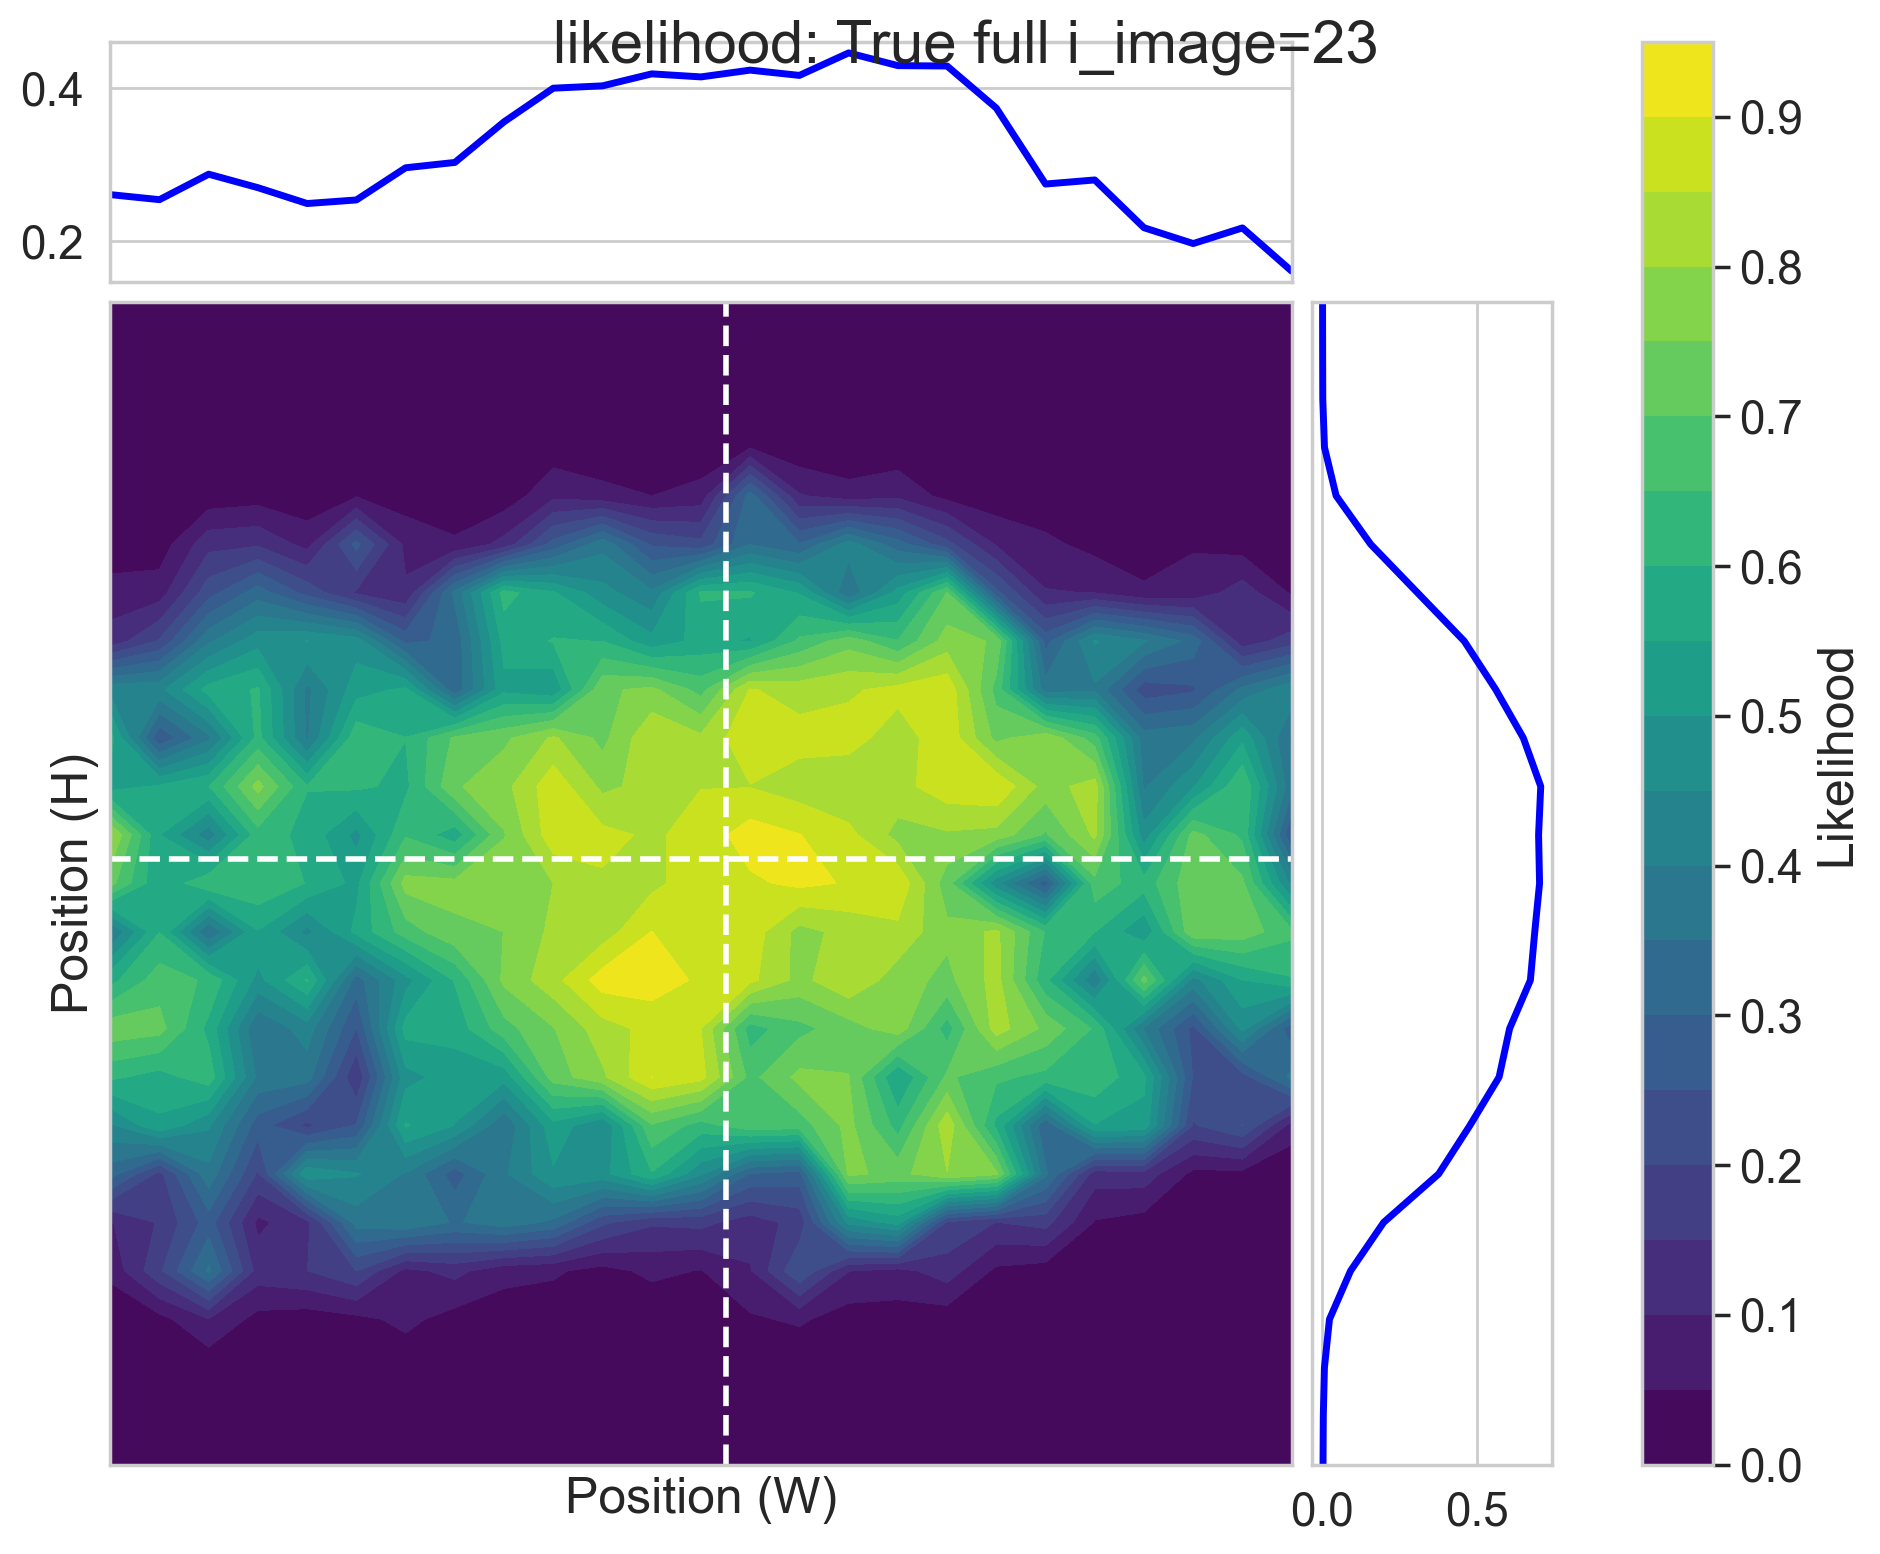

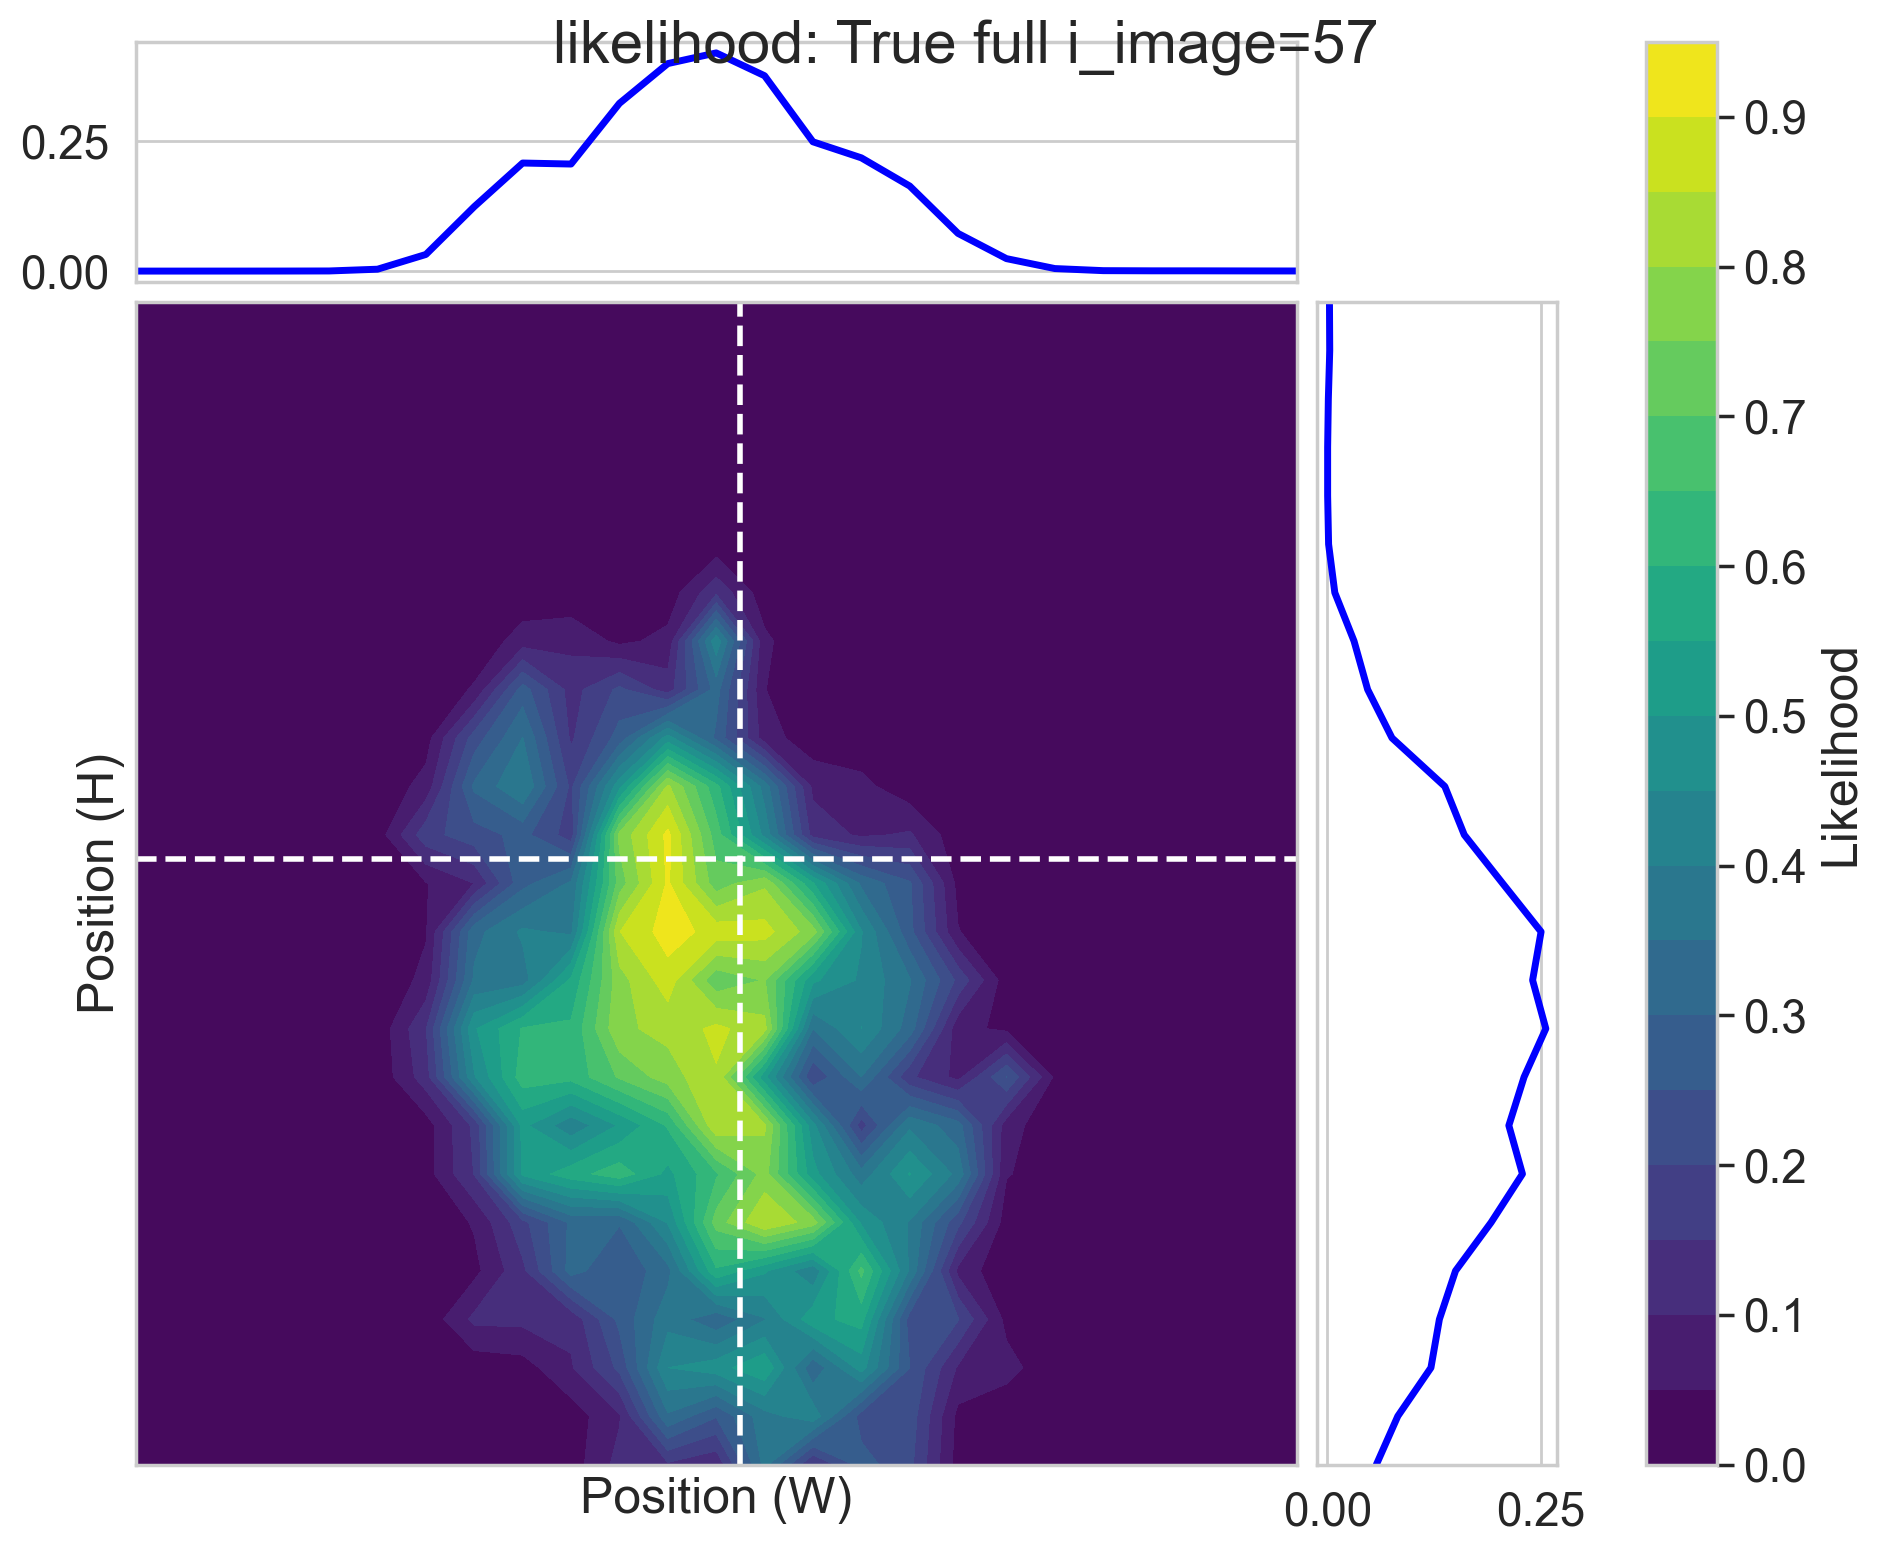

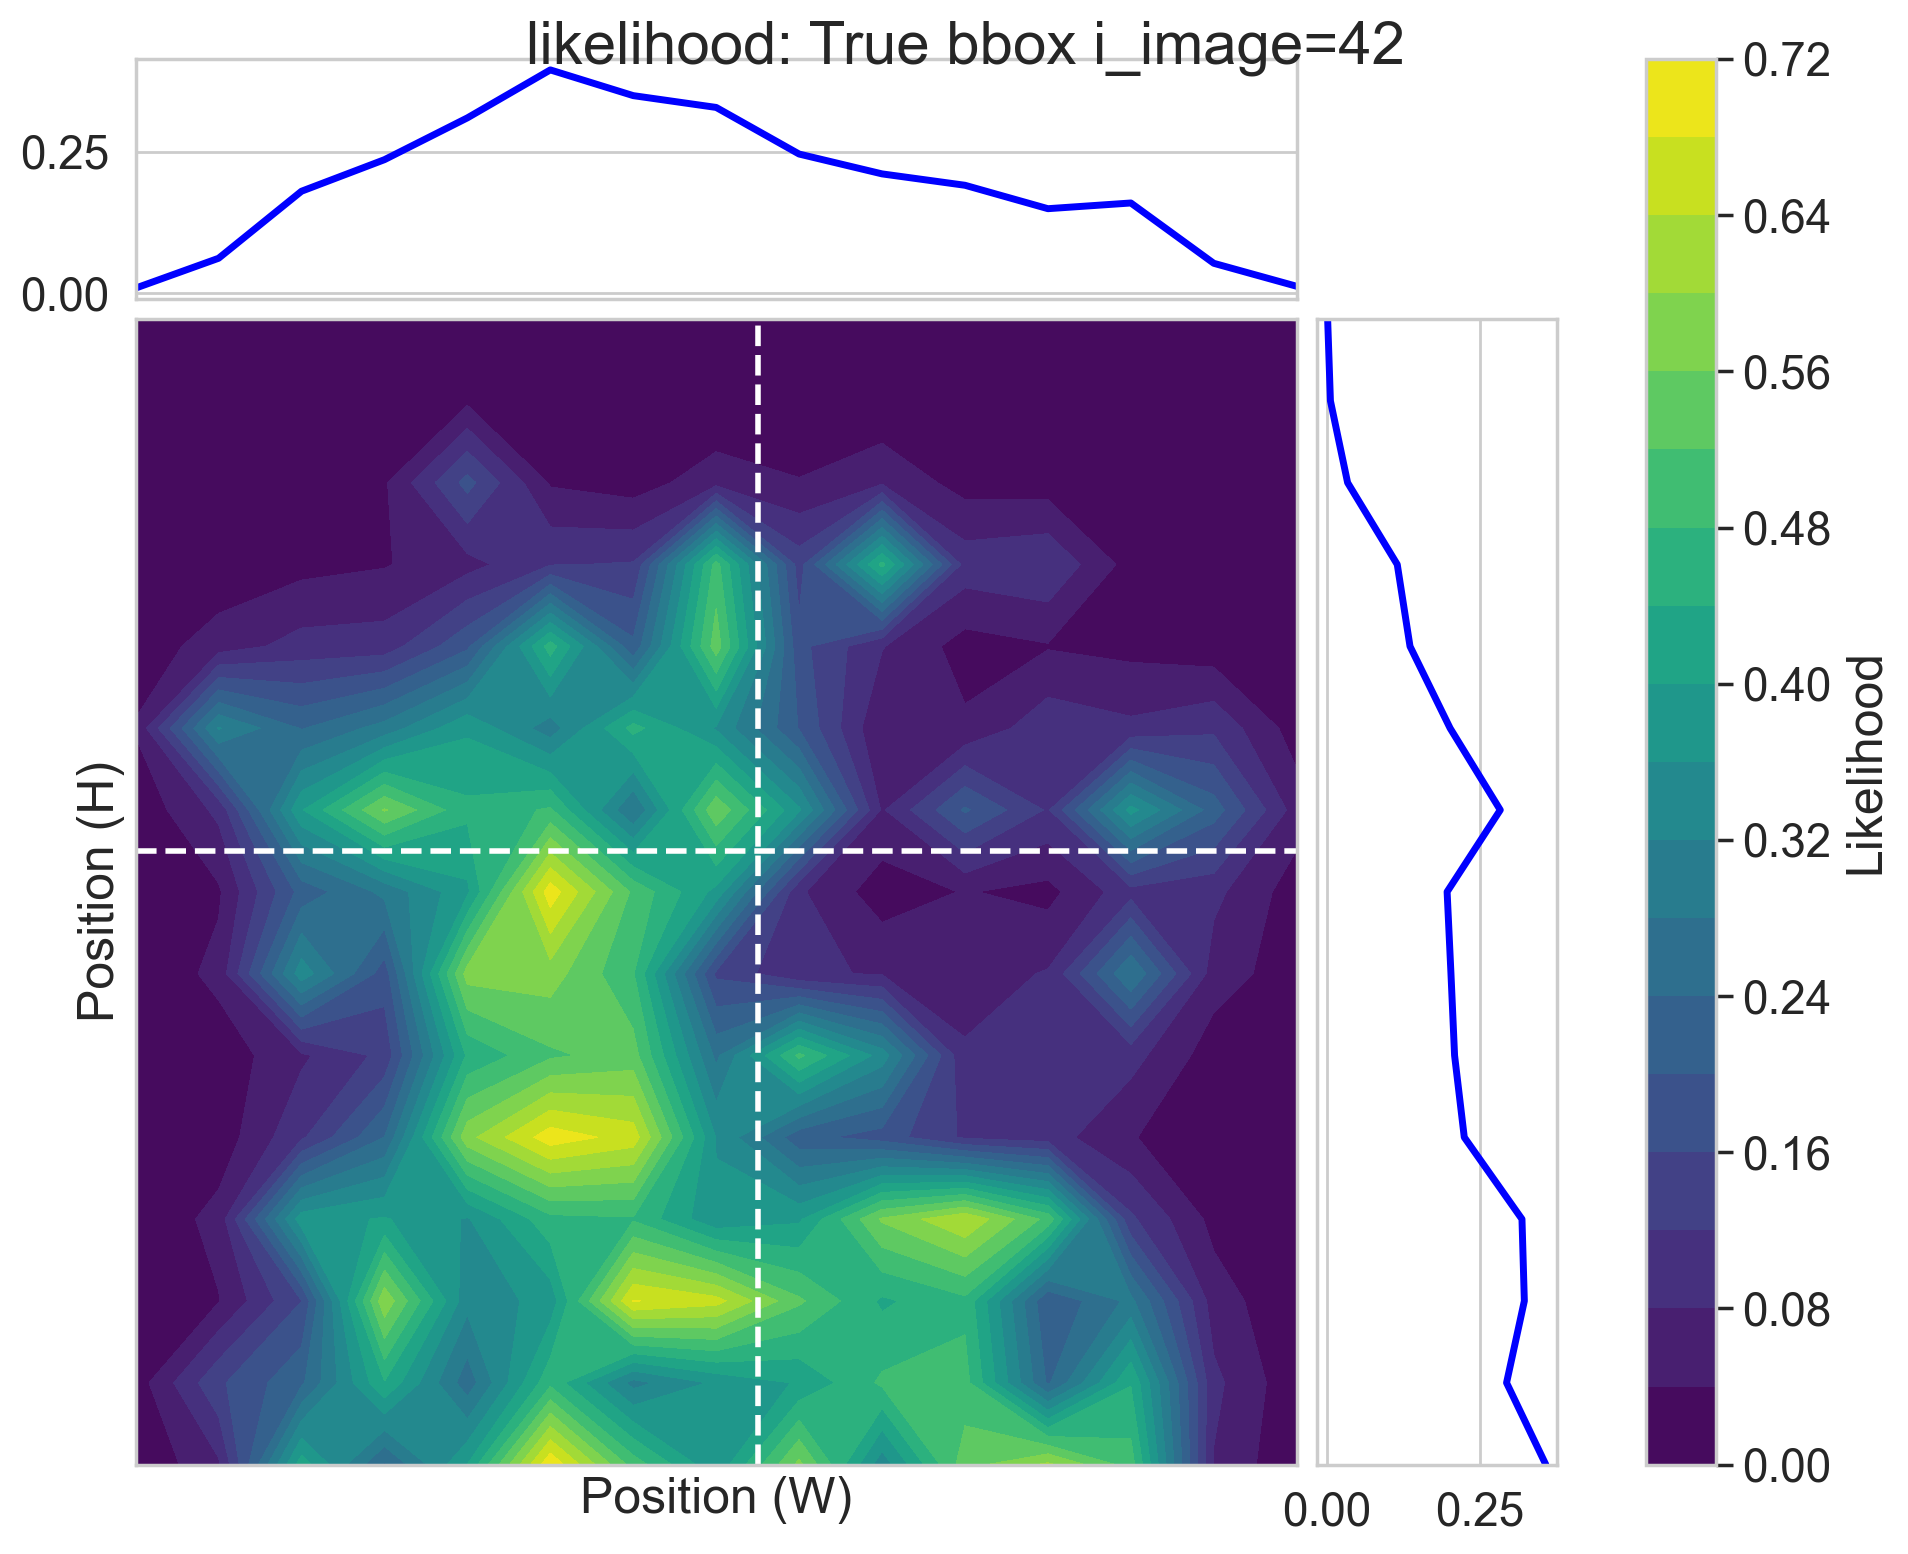

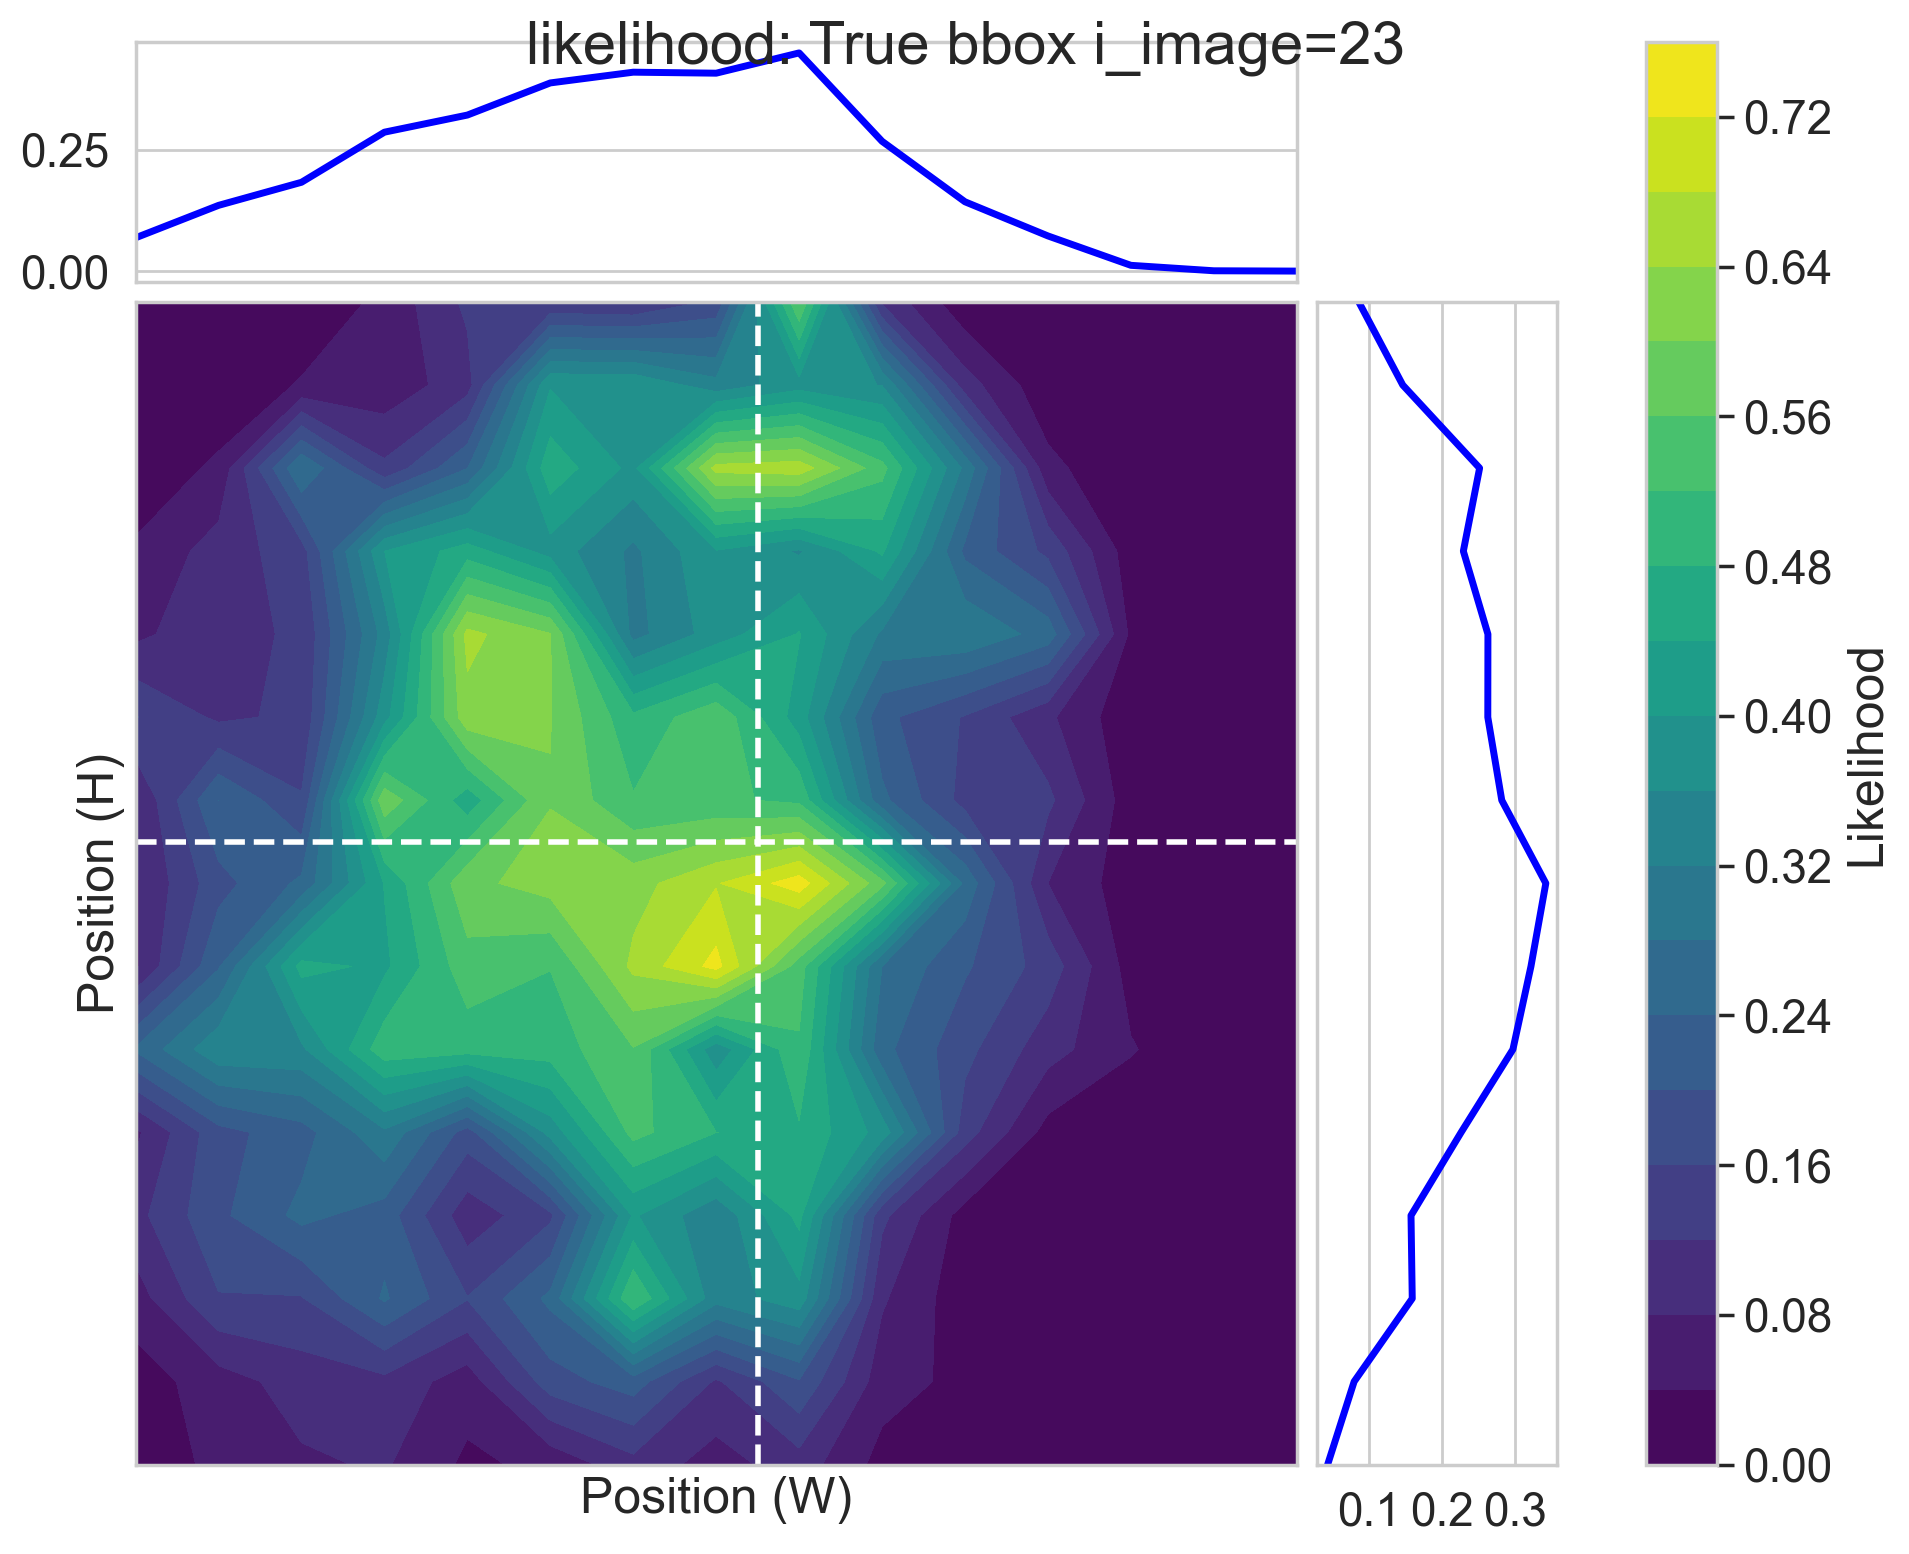

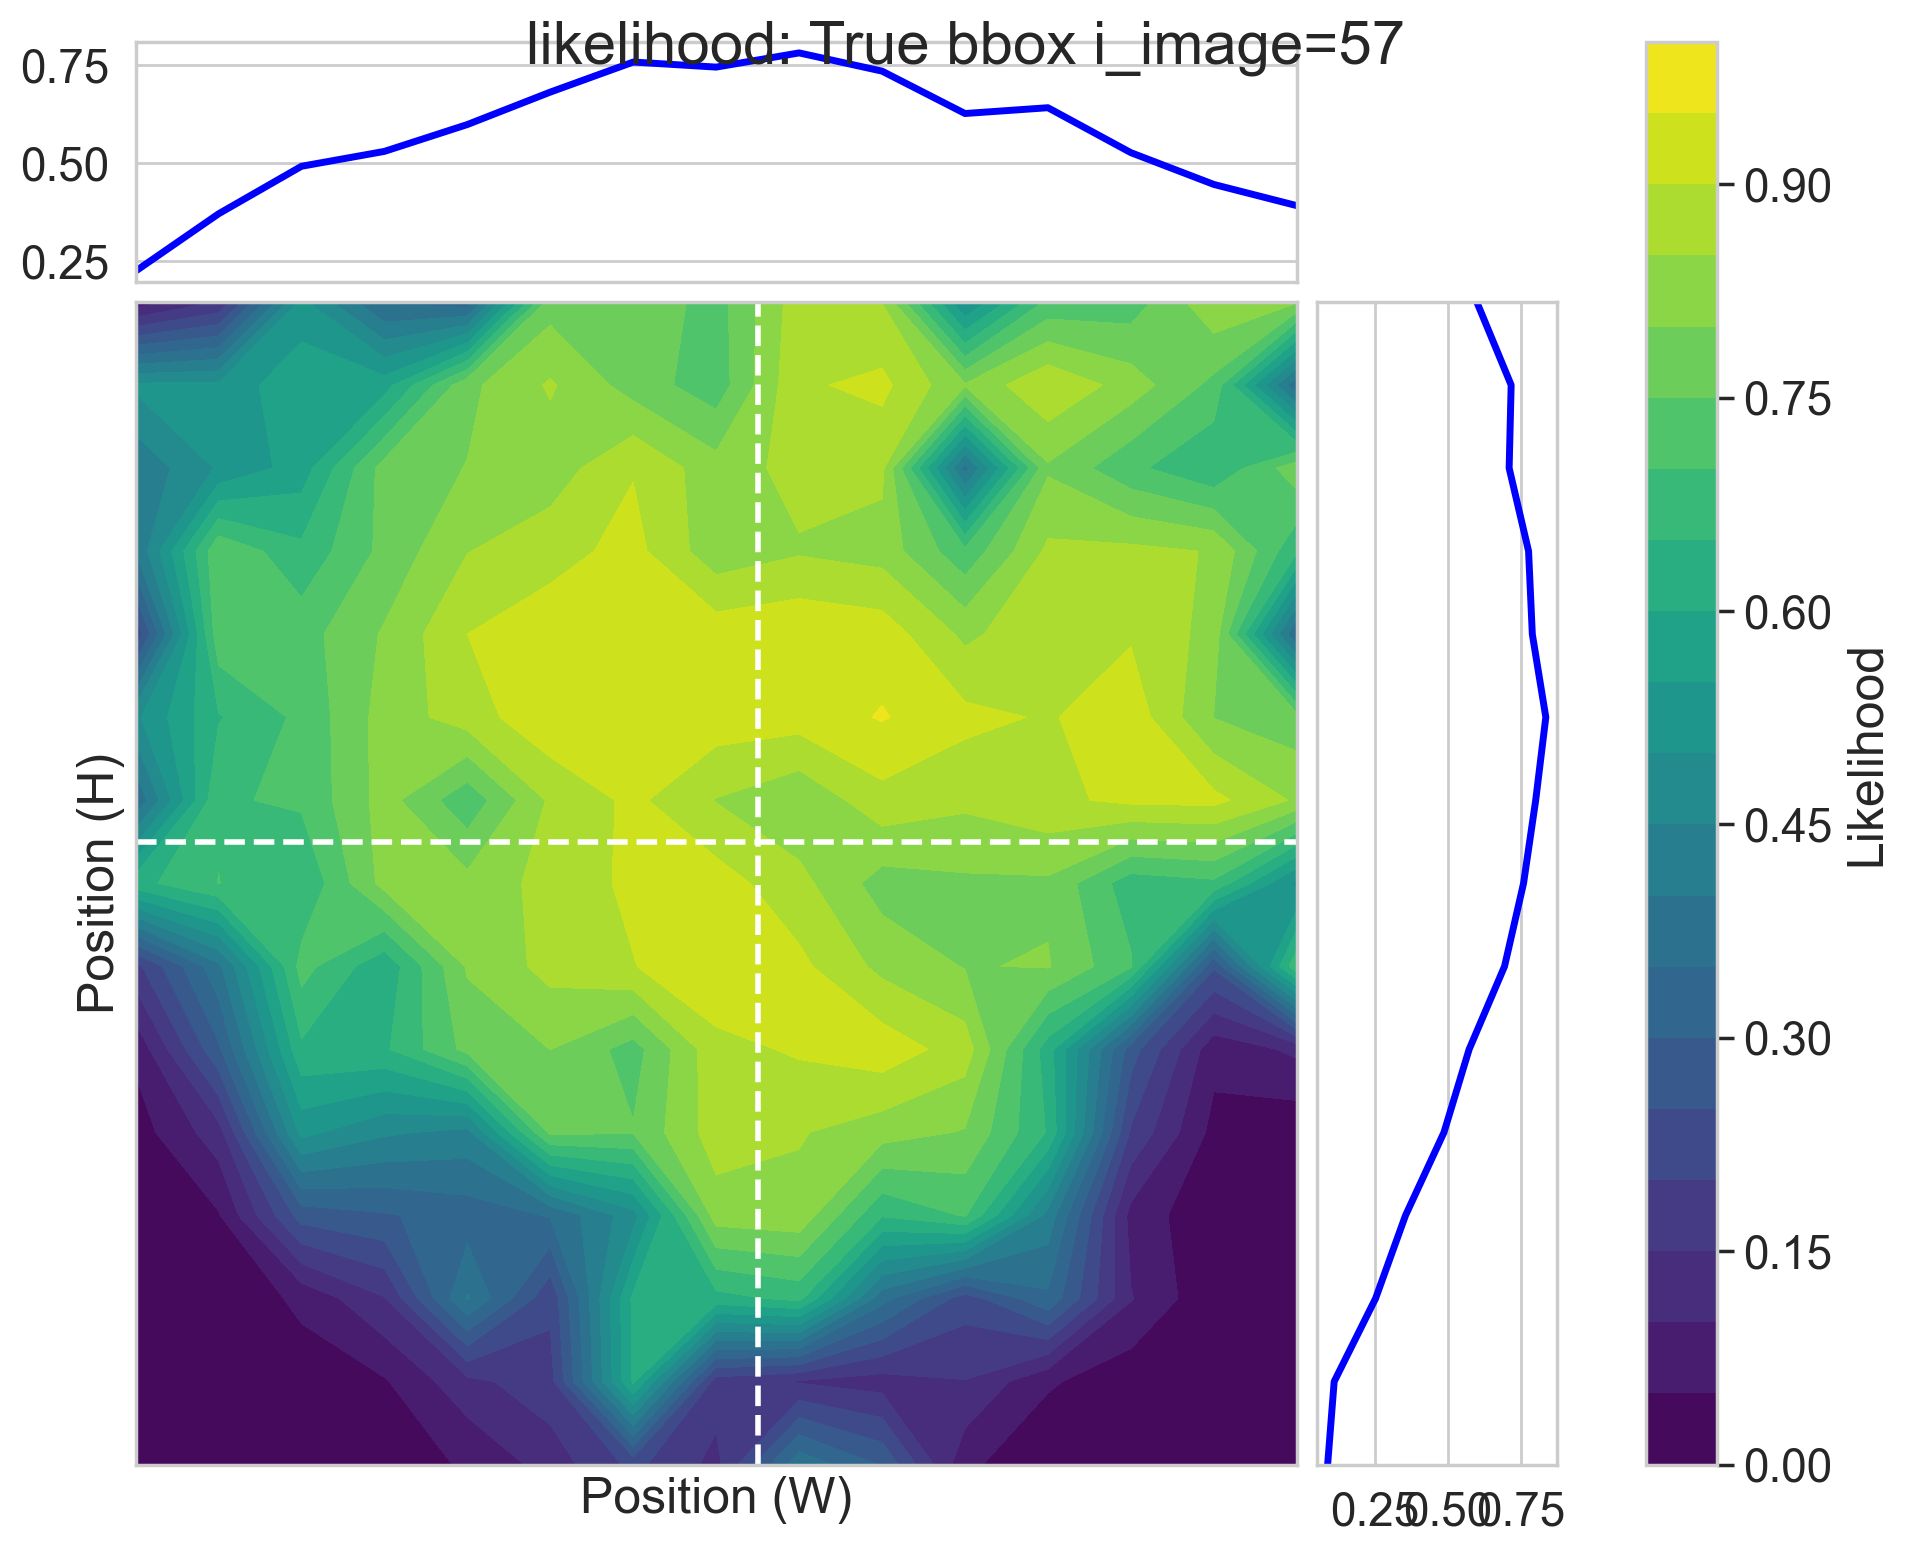

FileNotFoundError: [Errno 2] No such file or directory: 'cached_data/43_likelihood_maps_dataset=full_do_fovea=False.npz'

In [ ]:
# for do_fovea in [True, False]:
#     for dataset in fovea.params.all_datasets:
#         npz_filename = args.data_cache / f'43_likelihood_maps_dataset={dataset}_{do_fovea=}.npz'
#         with fovea.np.load(npz_filename) as data:
#             likelihood_maps_label = data['likelihood_maps_label']
#             likelihood_maps_max = data['likelihood_maps_max']

#         for i_image in [42, 23, 57]:
#             fig, axes = fovea.visualize_likelihood_map(likelihood_maps_label[:, :, i_image], sigma=.5)
#             fig.suptitle(f'likelihood: {do_fovea} {dataset} {i_image=}')
#             fovea.plt.show()

In [ ]:
# import pandas as pd
# data = []
# pos_H, pos_W = fovea.get_positions(1, 1, resolution=resolution)
# for do_fovea in [True, False]:
#     for dataset in fovea.params.all_datasets:
#         npy_filename = args.data_cache / f'43_likelihood_maps_dataset={dataset}_{do_fovea=}.npy'

#         likelihood_maps = fovea.np.load(npy_filename)

#         data_= pd.DataFrame({
#             'horizontal position': pos_H,
#             'vertical position': pos_W,
#             'probas': likelihood_maps.mean(axis=-1).T.flatcvten(),
#             'dataset': dataset,
#             'retinotopy': 'foveated' if do_fovea else 'uniform' 
#         })
#         data.append(data_)
# combined_data = pd.concat(data, ignore_index=True)
# combined_data

In [ ]:
# for do_fovea in [True, False]:
#     for dataset in fovea.params.all_datasets:
#         npy_filename = args.data_cache / f'43_likelihood_maps_dataset={dataset}_{do_fovea=}.npy'

#         likelihood_maps = fovea.np.load(npy_filename)

#         gaussian_df = fovea.compute_gaussian_params(likelihood_maps, sigma=.5)
                
#         g = fovea.sns.jointplot(
#             data=gaussian_df,
#             x="x0",
#             y="y0",
#             kind="scatter",
#             cmap="viridis",
#             # hue='retinotopy'
#         )
#         fovea.plt.show()

In [ ]:
# sigma = .5
# gaussian_max_dfs = {}
# gaussian_label_dfs = {}
# for do_fovea in [True, False]:
#     gaussian_label_dfs[do_fovea] = {}
#     gaussian_max_dfs[do_fovea] = {}
#     for dataset in ['bbox']: #fovea.params.all_datasets:     

#         npz_filename = args.data_cache / f'43_likelihood_maps_dataset={dataset}_{do_fovea=}.npz'
#         with fovea.np.load(npz_filename) as data:
#             likelihood_maps_label = data['likelihood_maps_label']
#             likelihood_maps_max = data['likelihood_maps_max']


#         gaussian_label_dfs[do_fovea][dataset] = fovea.compute_gaussian_params(likelihood_maps_label, sigma=sigma)
#         gaussian_max_dfs[do_fovea][dataset] = fovea.compute_gaussian_params(likelihood_maps_max, sigma=sigma)

In [ ]:
for do_fovea, c_fovea in zip([True, False], ['viridis', 'plasma']):
    for dataset in ['bbox']: #fovea.params.all_datasets:     
        g = fovea.sns.jointplot(
            data=gaussian_label_dfs[do_fovea][dataset],
            x="x0",
            y="y0",
            # kind="kde",
            cmap=c_fovea,
            title=f"{'foveated' if do_fovea else 'uniform'} - dataset={dataset}"
        )
        fovea.plt.show()

In [ ]:
import numpy as np

for dataset in ['bbox']: #fovea.params.all_datasets:     
    fig, ax = fovea.plt.subplots()

    for do_fovea, c_fovea in zip([True, False], ['skyblue', 'green']):
        print(dataset, do_fovea)       
        gaussian_df = gaussian_max_dfs[do_fovea][dataset]
        g = fovea.sns.histplot(
            ax=ax,
            data=gaussian_df,
            x='sigma',
            bins=40,
            element='step',  # Use step plots for clarity
            kde=False,  # Disable KDE for log-scaled x-axis
            color=c_fovea,
            alpha=0.7,
            edgecolor='black',
            log_scale=(True, False)  # Log scale only for the x-axis
        )

        # Compute the peak (bin with the highest count)
        counts, bin_edges = np.histogram(np.log(gaussian_df['sigma']), bins=40)
        peak_bin_index = np.argmax(counts)
        log_peak_value = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2  # Midpoint of the peak bin
        peak_count = counts[peak_bin_index]
        peak_value = np.exp(log_peak_value)

        # Annotate the peak on the plot
        fovea.plt.axvline(x=peak_value, color='red', linestyle='--', label=f'Peak: {peak_value:.2f}')
        fovea.plt.text(
            1.3,
            108,
            f' Peak @ {peak_value:.2f}',
            ha='center',
            va='bottom',
            color='red',
            fontsize=24,
            bbox=dict(facecolor='white', alpha=0., edgecolor='none')
        )        
    fovea.plt.show()

# comparing effect of size

In [ ]:
dataset = 'bbox'
VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, do_full_preprocess=False)
val_loader = fovea.get_loader(args, val_dataset)
model_filename = args.data_cache /  f'32_fovea_model_name={args.model_name}_dataset=bbox.pth'
model = fovea.load_model(args, model_filename=model_filename)

size_ratios = fovea.np.linspace(0, 1, 9, endpoint=True)[1:-1]

for size_ratio_ in size_ratios:
    args = fovea.Params(do_fovea=True, batch_size=1, subset_factor=subset_factor)
    npz_filename = args.data_cache / f'43_likelihood_maps_size_ratio={size_ratio_:.3f}.npz'
    # %rm {npz_filename}  # FORCING RECOMPUTE
    if npz_filename.exists():
        with fovea.np.load(npz_filename) as data:
            likelihood_maps_label = data['likelihood_maps_label']
            likelihood_maps_max = data['likelihood_maps_max']

    else:
        print('computing ', npz_filename)
        n_dataset = len(val_dataset)
        likelihood_maps_label = fovea.np.empty((resolution[0], resolution[1], n_dataset))
        likelihood_maps_max = fovea.np.empty((resolution[0], resolution[1], n_dataset))
        for i_batch, (image, true_idx) in fovea.tqdm(enumerate(val_loader), total=n_dataset):
            image = image.to(args.device)
            image = image.squeeze(0)
            three, H, W = image.shape

            if max((H, W)) > image_size_full:
                image = resize(image, image_size_full, interpolation=InterpolationMode.BILINEAR, antialias=True)

            # image = fovea.squarify(image)

            three, H, W = image.shape
            pos_H, pos_W = fovea.get_positions(H, W, resolution=resolution)
            probas = fovea.compute_likelihood_map(args, model, image, pos_H, pos_W, size_ratio=size_ratio_)

            likelihood_maps_label[:, :, i_batch] = probas[:, true_idx].cpu().numpy().reshape(resolution)
            proba_max, _ = probas.max(axis=-1)
            likelihood_maps_max[:, :, i_batch] = proba_max.cpu().numpy().reshape(resolution)

        fovea.np.savez(npz_filename, 
            likelihood_maps_max=likelihood_maps_max,
            likelihood_maps_label=likelihood_maps_label,
            )

In [ ]:
for size_ratio_ in size_ratios:
    args = fovea.Params(do_fovea=True, batch_size=1, subset_factor=subset_factor)
    npz_filename = args.data_cache / f'43_likelihood_maps_size_ratio={size_ratio_:.3f}.npz'
    with fovea.np.load(npz_filename) as data:
        likelihood_maps_label = data['likelihood_maps_label']
        likelihood_maps_max = data['likelihood_maps_max']

    print(npz_filename, npz_filename.exists())


In [ ]:
for i_image in [42, 23, 57]:
    for size_ratio_ in size_ratios:
        args = fovea.Params(do_fovea=True, batch_size=1, subset_factor=subset_factor)
        npz_filename = args.data_cache / f'43_likelihood_maps_size_ratio={size_ratio_:.3f}.npz'
        with fovea.np.load(npz_filename) as data:
            likelihood_maps_label = data['likelihood_maps_label']
            likelihood_maps_max = data['likelihood_maps_max']

        fig, axes = fovea.visualize_likelihood_map(likelihood_maps_label[:, :, i_image], sigma=.5)
        fig.suptitle(f'likelihood: size_ratio={size_ratio_:.3f} - {i_image=}')
        fovea.plt.show()